<h1> Ensemble generation submission and analysis notebook </h1>

This script uses a combination of bash and python cells to form a workflow for creating and analysing FATES (or any CLM) ensembles. It will:

<ol>
<li>Clone the github repo 
<li>Make and build a default 4x5 CLM-FATES case
<li>Make an ensemble of CLM-FATES cases 
<li>Generate an ensemble of parameter files with one at a time or latin hypercube  modification
<li>Point each ensemble member at a different parameter file
<li>Submit all these jobs
<li>Analyse output
</ol>

n.b. This notebook is also set up to work with Cheyenne specific paths, but can be modified. 

The version here is relatively simple in that it just submits a one at a time sensemble and plots maps of the output. Obviously much more can be made of the ensemble design and analysis but this is here as a generic tool... 

#### INITIALISE: Control variables for the analysis script.

In [1]:
# This mega script does 
# ensemble setup (including parameter file generation.  
# job submission and 
# analysis. 

# You can turn these off and on according to where you are tin the process. 

dosetup      = 1 # do we want to create parameters files and so on?
dosubmit     = 1 # do we do the submission stage, or just the analysis?
forcenewcase = 0 # do we scurb all the old cases and start again?
doanalysis   = 0 # do we want to plot the outputs? 
doilamb      = 0 # do we want to run the ilamb analysis?
doilambplots = 
print("setup, submit, analysis:", dosetup,dosubmit,doanalysis,doilamb)

#### INITIALISE: Define parameter space for senstivity analysis. 

#aspiration to make this into a dictionary...
#=========================================================
n = 6 # Ensemble Identification number
#==========================================================

if(n == 1):
    parameter_list=['fates_rad_leaf_clumping_index','fates_rad_leaf_xl',
                'fates_rad_leaf_rhovis','fates_rad_stem_rhovis',
                'fates_rad_leaf_tauvis','fates_rad_stem_tauvis' ,
               'fates_vai_top_bin_width','fates_vai_width_increase_factor']
    parameter_label=['clumping_index','leaf_xl',
                'leaf_rhovis','stem_rhovis',
                'leaf_tauvis','stem_tauvis' ,
               'top_bin_width','width_increase_factor']
    nparams = 8
    pmode = 1 #mode of varying the parameters. OAAT. 
    #how many members are in the ensemble?
    sp=1 #are we using SP mode?
    ncases=nparams*2
    min_delta=[0.5,   0.01,0.75, 0.75, 0.75,0.75, 0.25, 1.1]
    max_delta=[1/0.85,1.4 ,1.25, 1.25, 1.25,1.25, 0.5, 1.25]
    abs0_rel1 = [1, 1, 1, 1, 1, 1, 1]
    
# ensemble 2 is to look at a range of absolute values of xl
if(n == 2):
    pvalue=[-0.99, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 0.99]
    ncases = 8 #(this is zero indexed)
    parameter_list=['fates_rad_leaf_xl']
    pmode = 2 #just vary this one parameter. 
    parameter_label=['leaf_xl']
    sp=1 #are we using SP mode
    abs0_rel1 = [1]
    
if(n == 3):
    parameter_list='fates_vai_top_bin_width','fates_vai_width_increase_factor'
    parameter_label=['top_bin_width','width_increase_factor']
    pvalue1=[1, 1, 1, 1,
             0.5,  0.5, 0.5, 0.5,
             0.2, 0.2, 0.2, 0.2,
             0.1, 0.1, 0.1, 0.1,
             0.05, 0.05, 0.05, 0.05]
    pvalue2=[1.0, 1.1, 1.2, 1.3,
             1.0, 1.1, 1.2, 1.3,
             1.0, 1.1, 1.2, 1.3,
             1.0, 1.1, 1.2, 1.3,
             1.0, 1.1, 1.2, 1.3]
    ncases = 19 # not sure why this is n-1 but it is.     
    pmode = 3 # vary in an array
    abs0_rel1 = [0, 0] # how to modify the parameters. 
    parameter_label=['bin_wid', 'inc_f']
    sp=1 #are we using SP mode?

if(n==4):
    parameter_list=['fates_rad_leaf_clumping_index','fates_rad_leaf_xl',
                'fates_rad_leaf_rhovis','fates_rad_stem_rhovis',
                'fates_rad_leaf_tauvis','fates_rad_stem_tauvis']
    parameter_label=['clumping_index','leaf_xl',
                'leaf_rhovis','stem_rhovis',
                'leaf_tauvis','stem_tauvis' ]
    nparams = 6
    pmode = 1 #OAAT. 
    #how many members are in the ensemble?
    sp=1 #are we using SP mode?
    ncases=nparams*2
    min_delta=[0.5,   0.01,0.75, 0.75, 0.75,0.75, 0.25, 1.1]
    max_delta=[1/0.85,1.4 ,1.25, 1.25, 1.25,1.25, 0.5, 1.25]
    abs0_rel1 = [1, 1, 1, 1, 1, 1, 1]

    print(parameter_list)  

if(n == 5):
    parameter_list='fates_leaf_vcmax25top','fates_leaf_stomatal_slope_ballberry'
    parameter_label=['vcmax_top','BB slope']
    pvalue1=[0.6, 0.6, 0.6, 0.6, 0.6,
             0.8, 0.8, 0.8, 0.8, 0.8,
             1.0, 1.0, 1.0, 1.0, 1.0,
             1.2, 1.2, 1.2, 1.2, 1.2,
             1.4, 1.4, 1.4, 1.4, 1.4]
    pvalue2=[0.6, 0.8, 1.0, 1.2, 1.4,
             0.6, 0.8, 1.0, 1.2, 1.4,
             0.6, 0.8, 1.0, 1.2, 1.4,
             0.6, 0.8, 1.0, 1.2, 1.4,
             0.6, 0.8, 1.0, 1.2, 1.4]
    ncases = 24 # n-1 to account for zero indexing.     
    pmode = 3 #vary in an array
    sp=1 #are we using SP mode?
    abs0_rel1 = [1, 1]

# redo leaf layering ensemble where clumping == 1 
if(n == 6): 
    parameter_list='fates_vai_top_bin_width','fates_vai_width_increase_factor'
    parameter_label=['top_bin_width','width_increase_factor']
    pvalue1=[1, 1, 1, 1,
             0.5,  0.5, 0.5, 0.5,
             0.2, 0.2, 0.2, 0.2,
             0.1, 0.1, 0.1, 0.1,
             0.05, 0.05, 0.05, 0.05]
    pvalue2=[1.0, 1.1, 1.2, 1.3,
             1.0, 1.1, 1.2, 1.3,
             1.0, 1.1, 1.2, 1.3,
             1.0, 1.1, 1.2, 1.3,
             1.0, 1.1, 1.2, 1.3]
    ncases = 19 # not sure why this is n-1 but it is.     
    pmode = 3 # vary in an array
    abs0_rel1 = [0, 0] # how to modify the parameters. 
    parameter_label=['bin_wid', 'inc_f']
    sp=1 #are we using SP mode?


SyntaxError: invalid syntax (3652156408.py, line 13)

#### INITIALISE: Import libraries

In [ ]:
import os
import netCDF4 as nc4
import sys
import shutil
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from matplotlib import pyplot as plt
#import datetime

#### INITIALISE: Set pathnames for parameter directories and casenames.

In [ ]:
# what is your clone of the ctsm repo called? (or you want it to be called?) 
ctsmrepo='ctsmsep22'

#what do you want the directory with the ensemble cases in to be called?
ens_directory='RTM_ens'+str(n)

#what do you want the case names to begin with?
caseroot=ens_directory+'_case_'

USER='rfisher'

#path to scratch (or where the model is built.)
output_dir='/glade/scratch/'+USER+'/'

#where are we now?
notebookdr=os.getcwd() 

# git directory. aka where do you want the code and scripts to live?
gitpath = '/glade/work/'+USER+'/'

# some more derived path names to simplify latter scripts
scriptsdir=gitpath+'/git/'+ctsmrepo+'/cime/scripts/'


#### INITIALISE: SP/NOCOMP specific paths to default case/param files

In [ ]:
if(sp == 1): #Settings for the SP ensemble.
    resub=0 #how many times to resubmit the model. 

    #what is the name of your 'basecase'?
    defcase='fates_crops_smo_minlai_opt_vcmax50'
    
    #what is the base parameter file called?
    paramfiledefault='fates_params_default.nc'    

else: #Settings for the NOCOMP ensemble. 
    resub=2 #how many times do we want to resubmit the job?
    
    #what is the name of your 'basecase'?
    defcase='SPdefault_sept'
    
    #what is the base parameter file called?
    paramfiledefault='fates_params_default.nc'   
    
#set up the parameter file paths even if not in 'setup' mode
paramsdir = scriptsdir+'/'+ens_directory+'/parameter_files'
defparamdir = gitpath+'/git/'+ctsmrepo+'/src/fates/parameter_files/'

#case charecteristics
compset='2000_DATM%GSWP3v1_CLM50%FATES_SICE_SOCN_MOSART_SGLC_SWAV_SESP'
resolution = 'f45_f45_mg37'

#### INITIALISE: Make a function that creates directories if they don't already exist

In [ ]:
def make_directory(fileroot):   
    if(os.path.isdir(fileroot)):
        print('dir exists:'+fileroot)
    else:
        os.mkdir(fileroot)
        print('made: '+fileroot)

#### SETUP: Make a git repo if needed. 

In [ ]:
make_directory(gitpath+'git')

#### SETUP: Clone CTSM repo (if necessary). BASH

In [ ]:
%%bash -s "$ctsmrepo" "$dosetup"
ctsmrepo=$1
dosetup=$2

if [ $dosetup -eq 1 ]
then
cd /glade/work/$USER/git
#go to git directory
pwd
#go to git repo, or checkout code
if [[ -d "$ctsmrepo" ]]
then
cd $ctsmrepo
echo "Already have ctsm repo"
else
echo "Cloning ctsm"
#clone CTSM code if you didn't to this already. 
git clone https://github.com/escomp/ctsm $ctsmrepo
cd $ctsmrepo
./manage_externals/checkout_externals
cd src
fi
fi


#### SETUP: Make a default FATES 4x5 case BASH 

In [ ]:
create_command='./create_newcase --case '+defcase+' --compset '+compset+' --res '+resolution+' --run-unsupported'
print(create_command)
if(dosetup == 1):
    os.chdir(scriptsdir)
    if(os.path.isdir(defcase)):
        print("defcase exists on your filesystem.")
    else:
        print("making defcase.",defcase)         
        os.system(create_command+' ')
        os.chdir(defcase)
        os.system('./case.setup')
        os.system('./case.build')
os.chdir(notebookdr)

#### SETUP: Adjust settings of default case.  

In [ ]:
os.chdir(scriptsdir+defcase)
print('updating settings')
os.system('./xmlchange CONTINUE_RUN=FALSE')
os.system('./xmlchange --id STOP_N --val 3')
os.system('./xmlchange --id STOP_OPTION --val nyears')
os.system('./xmlchange --id CLM_FORCE_COLDSTART --val on')
os.chdir(notebookdr)
print('done with xmlchanges')

#### SETUP: Make ensemble and parameter directory

In [ ]:
make_directory(scriptsdir+ens_directory)
make_directory(scriptsdir+ens_directory+'/parameter_files' )

#### SETUP: Make ensemble of CLM cases BASH

In [ ]:
%%capture
%%bash -s "$scriptsdir" "$defcase" "$dosetup" "$ens_directory" "$caseroot" "$ncases" "$forcenewcase"

scriptsdir=$1
defcase=$2
dosetup=$3
ens_directory=$4
caseroot=$5
ncases=$6
forcenewcase=$7

echo "ncases=" $ncases
echo "caseroot=" $caseroot
echo "dosetup=" $dosetup
echo "forcenewcase=" $forcenewcase
echo "ens_directory=" $ens_directory

if [[ $dosetup -eq 1 ]]
then
cd $scriptsdir

counter1=0 #include a default zero case. 
while [ $counter1 -le $ncases  ]
do
  newcase=$caseroot$counter1 #name of ensemble membr case.    
  if [ -d $ens_directory/$newcase ]
  then
    echo ' new case already exists',$ens_directory/$newcase
    if [ $forcenewcase -eq 1 ]
    then
    echo 'force making case', $ens_directory/$newcase
    rm -rf $ens_directory/$newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    cd $ens_directory/$newcase
    echo 'case setup', $ens_directory/$newcase
    ./case.setup;
     cd ../../ 
    fi    
  else
   echo 'making new case', $ens_directory/$newcase
    ./create_clone --clone $defcase --case $ens_directory/$newcase ;
    cd $ens_directory/$newcase
    echo 'case setup', $ens_directory/$newcase
    ./case.setup;
    cd ../../ 
  fi
((counter1++))
done

fi

#### SETUP: Create/ncgen a .nc version of current default (.cdl) file. 

In [ ]:
if(dosetup == 1): 
    newfilenc=defparamdir+'fates_params_default.nc'
    template_cdl=defparamdir+'fates_params_default.cdl'

    if(os.path.isfile(newfilenc)):
       os.remove(newfilenc)    
    os.system('ncgen '+template_cdl+' -o '+newfilenc)
    os.listdir(defparamdir)

#### SETUP: Copy default template parameter file to ensemble parameter directory

In [ ]:
if(dosetup == 1): 
    filename_template = paramsdir+'/'+paramfiledefault
    print(filename_template)
    if(os.path.isfile(filename_template)):
       os.remove(filename_template)    
    shutil.copy(newfilenc,filename_template)

#### SETUP: Make a default user_nl_clm file

In [ ]:
if (dosetup == 1 ):
    defcasedir = scriptsdir+'/'+defcase #where is the vanilla file?
    os.chdir(defcasedir) #go to the def case dir

    if(os.path.isfile('user_nl_clm_default')):
        #squash the existing default file
        os.remove('user_nl_clm_default')
    else:    
        #move the vanilla version to the default version
        shutil.copy(user_nl_clm, user_nl_clm_default)

#### SETUP: Write configuration and dummy parameter filename into defualt user_nl_clm file

In [ ]:
if (dosetup == 1 ):   
    f = open('user_nl_clm_default', 'a')
    if (sp ==1): #change to SP mode. 
        f.write('use_fates_sp = true')
        f.write('\n')
    f.write('fates_paramfile = "nullparameterfile"')
    f.close()
    # copy this 'fresh' default file into the ensemble directory. 
    shutil.copy('user_nl_clm_default', scriptsdir+'/'+ens_directory+'/user_nl_clm_default')
    
    #check what you made!
    os.system("cat user_nl_clm_default")
    os.chdir(notebookdr)
print('end')

#### SETUP: Create ensemble of parameter files

In [ ]:
if(dosetup == 1): 
    fatesparamfile= 'fates_params_'+ens_directory+'_'
    vs=range(0,ncases+1) 
    print(vs)
    for i in vs:
        filename_out = paramsdir+'/'+fatesparamfile+str(i)+'.nc' 
        #print('make:'+filename_out)
        try:
            os.remove(filename_out)
        except:
            print('file does not yet exist: '+filename_out)
        shutil.copy(filename_template,filename_out)
print('end')

#### SETUP: Make function to modify FATES parameter files. 

In [ ]:
def def_pftfile( fileroot,i,variable,abs_rel,delta):   
    pfilename = fileroot+str(i)+'.nc' 
    fin = nc4.Dataset(pfilename, 'r+')
    print('modifying parameter file',i,variable,delta);
    var = fin.variables[variable]
    if(abs_rel == 1): #relative peturbation
        var[:] = var[:]*delta
    if(abs_rel == 0): #absolute peturbation
        var[:] = var[:]*0+delta

    fin.close()

#### SETUP: Modify parameter files (one at a time)

In [ ]:
if(dosetup == 1): 
    fileroot =  paramsdir+'/'+fatesparamfile
    print(n)
    if(pmode == 1): #OAAT
        for p in range(0,nparams):
            def_pftfile(fileroot,p*2+1,parameter_list[p],abs0_rel1[p],min_delta[p])
            def_pftfile(fileroot,p*2+2,parameter_list[p],abs0_rel1[p],max_delta[p])

    if(pmode == 2): #single p variation. 
        for i in vs:
            def_pftfile(fileroot,i,parameter_list[0],abs0_rel1[p],pvalue[i])

    if(pmode == 3): #vary in a 2D array. 
        for i in vs:
            def_pftfile(fileroot,i,parameter_list[0],abs0_rel1[0],pvalue1[i])
            def_pftfile(fileroot,i,parameter_list[1],abs0_rel1[1],pvalue2[i])

    if(n ==4 | n ==5): #Modify the background leaf lavel parameers.
        for i in vs:
            def_pftfile(fileroot,i,'fates_vai_width_increase_factor',0,1.1)
            def_pftfile(fileroot,i,'fates_vai_top_bin_width',0,0.1)

    if(n == 5 or n == 6 ): #Set the clumping factor to 1. 
        for i in vs:
            def_pftfile(fileroot,i,'fates_rad_leaf_clumping_index',0,1.0)
            

#### SETUP: Point each ensemble script at different parameter file

In [ ]:
if(dosetup == 1): 
    root= scriptsdir+'/'+ens_directory+'/'
    vs=range(0,ncases+1) 
    print('paramsdir=',paramsdir)
    for i in vs:
        pftfilename = paramsdir+'/'+fatesparamfile+str(i)+'.nc'    
        unlfile=root+caseroot+str(i)+'/'+'user_nl_clm'
        defunl=scriptsdir+'/'+ens_directory+'/user_nl_clm_default' 
        #print('defult unl='+defunl)
        #print('case unl='+unlfile)
        shutil.copy(defunl,unlfile)
        #print('unl='+unlfile)   
        fin = open(unlfile, "rt")     
        data = fin.read()   #read file contents to string   
        data = data.replace('nullparameterfile',pftfilename) #replace all occurrences of the required string        
        fin.close() #close the input file       
        fin = open(unlfile, "wt") #open the input file in write mode     
        fin.write(data) #overrite the input file with the resulting data       
        fin.close() #close the file
!cat '/glade/work/rfisher/git/ctsmsep22/cime/scripts//RTM_ens1/RTM_ens1_case_7/user_nl_clm'

#### SETUP: Check parameter files were correctly modifed

In [ ]:
if(dosetup == 1):
    i=3
    paramnum=0
    pf= paramsdir+'/'+fatesparamfile+str(0)+'.nc' 
    print(pf)
    find = nc4.Dataset(pf, 'r+')
    vardef=find.variables[parameter_list[paramnum]]
    pf= paramsdir+'/'+fatesparamfile+str(i)+'.nc' 
    print(pf)
    finm = nc4.Dataset(pf, 'r+')
    varmod=finm.variables[parameter_list[paramnum]]
    if(pmode == 1):
        print('actual ratio:',np.divide(varmod[:],vardef[:]))
        print('target ratio:',min_delta[paramnum])
    if(pmode == 2):
        print('actual value:',varmod[:])
        print(pvalue[i])
    if(pmode == 3):
        print('actual value:',varmod[:])
        print(pvalue1[i])

#### SUBMISSION: Submit ensemble of cases

In [ ]:
%%capture
%%bash -s "$scriptsdir" "$defcase" "$ens_directory" "$caseroot" "$ncases" "$dosubmit" 

scriptsdir=$1
defcase=$2
ens_directory=$3
caseroot=$4
ncases=$5
dosubmit=$6
echo $dosubmit
if [ $dosubmit -eq 1 ]
then
cd $scriptsdir

echo 'submitting'
startcase=0
counter1=$startcase
cd $ens_directory

while [ $counter1 -le $ncases ]
do
  echo $counter1
  newcase=$caseroot$counter1
  echo $newcase

  if [ -d $newcase ]
  then
    cd $newcase
    cat user_nl_clm
    echo 'submitting job',$newcase
    ./xmlchange BUILD_COMPLETE=TRUE
    #./xmlchange RESUBMIT=1
   # ./xmlchange PROJECT=P93300041
    ./case.submit
    cd ../
  else
   echo 'no case', $newcase
  fi

  ((counter1++))
  done
else
echo "not submitting jobs"
fi

#### check progress of jobs


In [ ]:
rund=output_dir+caseroot+str(17)+'/run'
print(rund)
os.system('ls -lrt '+rund)

<h2>Analyse output</h2>

### Paths for analysis

In [ ]:
if doanalysis ==1: 
    output='/glade/scratch/rfisher/'
    conv = 3600*24*365
    yr='.clm2.h0.'   
    ychoose=2000
    delta=1
    print('ychoose=', ychoose)
    rel=1

#### ANALYSIS: Choose variables to read in

In [ ]:
vars=['FATES_GPP','FSR','SABV','SABG','EFLX_LH_TOT','FSH','lat','lon','time']

 #### ANALYSIS: Make output figure directory

In [ ]:
figpath = (notebookdr+'/'+ 'figs_'+ens_directory+'/')
make_directory(figpath)

####  ANALYSIS: Make a single data structure for the ensemble

In [2]:
print(output_dir)
if doanalysis ==1:
    debug=1
    hstring='.clm2.h0.'
    vs=range(0,ncases+1)
    count=1
    print(caseroot)
    print(vs)
    missing=range(0,ncases+1)
    missing=np.multiply(missing,0)
    for i in vs:       
        run=caseroot+str(i)
        os.listdir(output_dir + '/archive')
        arc = output_dir + 'archive/' + run + '/lnd/hist/' 
        #arc = output_dir + '/' + run+'/'
        hpath = arc
        tfile = run+hstring+str(ychoose)+'-02.nc'
        if(os.path.isdir(hpath)): 
            if(os.path.isfile(hpath+tfile)): 
                if debug == 1 :print('file in archive')
                missing[i]=0
            else:
                if debug == 1 :print('file not in archive',hpath+tfile)
        else:
            if(debug == 1):print('no archive')
            hpath = output_dir + run + '/run/'            
            if(os.path.isdir(hpath)): 
                print('is rundir',hpath)                
                if(os.path.isfile(hpath+tfile)):
                    if debug == 1 :print('file in  rundir')
                    missing[i]=0
                else:
                    print('no file in  rundir',hpath+tfile)
                    missing[i]=1
            else:
                print('no  rundir',hpath)
        if(missing[i]==0):
            allvars=list(xr.open_dataset(hpath+tfile, decode_times=False).variables)
            dropvars=list(set(allvars) - set(vars)) #thanks to Ben for figuring this part out :) 
            print('file'+str(i)+' ='+hpath+tfile)
            tmp=xr.open_mfdataset(hpath+tfile, decode_times=False, drop_variables=dropvars)

        if i==0:
            try: 
                del dsc
            except:
                print('no dsc')
            dsc = tmp           
        else:
            dsc=xr.concat([dsc,tmp],'ens')

print('end')

NameError: name 'output_dir' is not defined

####  ANALYSIS: Save data in netcdf file just incase

In [ ]:
#outfile=figpath+'/dataout.nc' 
#dsc.to_netcdf(outfile)
#os.listdir(figpath)

####  ANALYSIS:  Make a function to plot relative differences between runs

In [ ]:
def make_diff_figure(dsc,v,rel,conv,ncases,pmode,vlim,parameter_list):   
    fig = plt.figure()
    if(pmode == 1):
        plt.rcParams['figure.figsize'] = [27,7]
    if(pmode == 2):
        plt.rcParams['figure.figsize'] = [17,7]
    if(pmode == 3):
        plt.rcParams['figure.figsize'] = [12,10]
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    vs=range(0,ncases+1)
    if(pmode == 3):
        nrow=5
    else:
        nrow=2
    ncol=(ncases+1) // nrow
    count=1
    var_0=dsc[vars[v]].isel(ens=12)
    defm=np.multiply(np.mean(var_0,0),conv)
    print(vs)
    for i in vs:
        # organize plots depending on whether this is a OAAT or ensemble analysis 
        index=((count+1) % nrow)*ncol + ((count+1) // nrow)
        #print('i '+str(i))
        p=((count+1) // nrow)-1
        if(pmode == 3):index = i+1
        var_i=dsc[vars[v]].isel(ens=i)
        var_i=dsc[vars[v]].isel(ens=i) 
        mod=np.multiply(np.mean(var_i,0),conv)
        delt=mod-defm
        if(pmode == 1):
            if((count+1) % 2==0):
                ex=' x'+str(min_delta[p])
            else:
                ex=' x'+str(max_delta[p])
        if(pmode == 2):
            ex = ' x'+str(pvalue[i])
        if(pmode == 3):
            ex0 = ' ='+str(pvalue1[i])
            ex1 = ' ='+str(pvalue2[i])
        ax = fig.add_subplot(nrow, ncol, index)
        if(missing[i]==1):
            print('missing plot',i)
            
        else:         
            plt1=delt.plot(cmap='RdYlBu',vmin=-vlim,vmax=vlim)
                  
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        if pmode == 1 :ax.set_title(str(parameter_label[(((count+1) // 2))-1]+ex))
        if pmode == 2 : ax.set_title(str(parameter_label[0]+ex))
        if pmode == 3 : ax.set_title(parameter_label[0]+str(ex0)+' '+parameter_label[1]+str(ex1))

        count=count+1
        fig.canvas.draw()
       # time.sleep(1) 
        figname = figpath+ens_directory+vars[v]+'.png'
    print(figname)
    plt.savefig(figname)
    
          

### ANALYSIS: Plot model ensemble output

In [ ]:
conv=1;vlim=1
if doanalysis ==1:
    make_diff_figure(dsc,0,rel,3600*365*24,ncases,pmode,vlim,parameter_list)

In [ ]:
conv=1;vlim=8
if doanalysis ==1:
    make_diff_figure(dsc,1,rel,conv,ncases,pmode,vlim,parameter_list)

In [ ]:
conv=1;vlim=10
if doanalysis ==1:
    make_diff_figure(dsc,2,rel,conv,ncases,pmode,vlim,parameter_list)

In [ ]:
conv=1;vlim=5
if doanalysis ==1:
    make_diff_figure(dsc,3,rel,conv,ncases,pmode,vlim,parameter_list)

In [ ]:
conv=1;vlim=2.5
if doanalysis ==1:
    make_diff_figure(dsc,4,rel,conv,ncases,pmode,vlim,parameter_list)

In [ ]:
conv=1;vlim=3.5
if doanalysis ==1:
    make_diff_figure(dsc,5,rel,conv,ncases,pmode,vlim,parameter_list)

#### ILAMB: Set up pathsfor ensemble

In [ ]:
# where do you want to build the ILAMB data?
# this needs more generalizing. 
build_dirname=ens_directory
clm5_comp=1

ilamb_path   ='/glade/work/rfisher/ilamb/ILAMB/MODELS/'
build_path = ilamb_path+'/'+build_dirname+'/'+'_build2'

#ILAMB config file
config_file='ilamb_CLMFATES_SP.cfg'
config_path='../ilamb_scripts/config_files/'+config_file

#model setup path
model_setup_file='model_setup_fatesrtm.txt'
model_setup_path = '../ilamb_scripts/model_setup_files/'+ model_setup_file

#write a new model setup file
model_setup_path= 'model_setup_files/model_setup_'+ens_directory+'.txt'
print(model_setup_path)

#ILAMB regions file
ilamb_regions='region_files/LandRegions.nc'
print('ccwd='+os.getcwd())

try:
    os.remove(model_setup_path)
except: 
    print("no setup file")
vs=range(0,ncases+1)
modelarray = ["dummylist", "dummylist"]
# Make list of all models in ensemble
f = open(model_setup_path, "w")
for i in vs:       
    run=caseroot+str(i)
    if(i==0):
        if(clm5_comp==1):
            run='CLM50-SP'
    #models[i]=run
    msu_line=run+' , /glade/scratch/'+USER+'/archive/'+run+'/lnd/hist/'+" "
    if(i==0):
        list_models=run
        msu_list= msu_line
    else:
        list_models=list_models+" "+run
        msu_list= msu_list + msu_line
    modelarray.append(run) 
    f.write(msu_line)
    f.write('\n')
#f = open(model_setup_path, "w")
#f.writelines(msu_list)
f.close()
del modelarray[0:2]


#model_setup_file='model_setup_fatesrtm3.txt'
#model_setup_path = '../ilamb_scripts/model_setup_files/'+ model_setup_file
#list_models='RTM_ens3_case_1 RTM_ens3_case_10 RTM_ens4_case_1'

print('model config file='+ config_path)
print('model setup path='+model_setup_path)
print('ilamb_path='+ilamb_path)
print('list_models='+list_models)
print('build_path='+build_path)

In [ ]:
#model_setup_path='model_setup_files/model_setup_RTM_ens6.txt'
#models=['RTM_ens6_case_4','RTM_ens6_case_5','RTM_ens6_case_6']
#list_models=models[0]+' '+models[1]+' '+models[2]
#build_path='/glade/work/rfisher/ilamb/ILAMB/MODELS//fates_rtm/_build'

model_setup_files/model_setup_RTM_ens3.txt
ccwd=/glade/u/home/rfisher/fates-global-cal/ilamb_scripts
model config file=../ilamb_scripts/config_files/ilamb_CLMFATES_SP.cfg
model setup path=model_setup_files/model_setup_RTM_ens3.txt
ilamb_path=/glade/work/rfisher/ilamb/ILAMB/MODELS/
list_models=CLM50-SP RTM_ens3_case_1 RTM_ens3_case_2 RTM_ens3_case_3 RTM_ens3_case_4 RTM_ens3_case_5 RTM_ens3_case_6 RTM_ens3_case_7 RTM_ens3_case_8 RTM_ens3_case_9 RTM_ens3_case_10 RTM_ens3_case_11 RTM_ens3_case_12 RTM_ens3_case_13 RTM_ens3_case_14 RTM_ens3_case_15 RTM_ens3_case_16 RTM_ens3_case_17 RTM_ens3_case_18 RTM_ens3_case_19
build_path=/glade/work/rfisher/ilamb/ILAMB/MODELS//RTM_ens3/_build

### ILAMB: Submit ILAMB script (BASH)

In [ ]:
%%bash -s "$config_path" "$model_setup_path" "$ilamb_path" "$ilamb_regions" "$list_models" "$build_path" "$doilamb"

config_path=$1  
model_setup_path=$2
ilamb_path=$3
ilamb_regions=$4
list_models=$5
build_path=$6
doilamb=$7

#PBS -N ilamb_diagnostics*
#PBS -q regular
#PBS -l select=4:ncpus=2:mpiprocs=2:mem=109GB
#PBS -l walltime=12:00:00
#PBS -A P93300041
#PBS -j oe
#PBS -k eod
#PBS -m abe
#PBS -M oleson@ucar.edu

echo $config_path
echo $model_setup_path
echo $list_models
echo $ilamb_path
echo $build_path
echo $doilamb

#export BUILD_DIRNAME fates_rtm
if [ $doilamb -eq 1 ]
then
#conda init bash
source /glade/work/oleson/miniconda3/etc/profile.d/conda.sh

export MPI_UNBUFFERED_STDIO=true
export TMPDIR=$TMPDIR
mkdir -p $TMPDIR

conda activate ilamb
export MPLBACKEND=Agg

#do not delete this. 
export ILAMB_ROOT=/glade/p/cesm/lmwg_dev/oleson/ILAMB/ILAMB_all

echo "submitting ilamb"
#rosie modifications
mpiexec_mpt dplace -s 1 ilamb-run --config $config_path \
--model_root $ilamb_path \
--models  $list_models \
--build_dir $build_path \
--define_regions $ilamb_regions \
--model_setup $model_setup_path \
--filter  .clm2.h0. \
--skip_plots \
--confrontation Albedo/CERES LatentHeat/GBAF GrossPrimaryProductivity/GBAF

#>> ${log_filename} 2>&1

fi

#### Read in and plot ILAMB ensemble outputs 

#### ILAMB PLOTS: generic output plotter

In [ ]:
def ensemble_bias(variable,vlc,vgroup,product_name,vmn,vmx):   
   
    fig = plt.figure()
    output_pth=build_path+'/'+vgroup+'/'+variable+'/'+product_name+'/'
    plt.rcParams['figure.figsize'] = [30,22]
    vs=range(0,ncases+1)
    arrscore = [None] * (ncases+1)
    
    for i in vs:
        ifile = product_name+'_'+modelarray[i]+'.nc'
        #ifile = product_name+'_'+caseroot+str(i)+'.nc'

        
        if(pmode == 3):
            ex0 = ' ='+str(pvalue1[i])
            ex1 = ' ='+str(pvalue2[i])
        if pmode == 3 :
             axtitle=parameter_label[0]+str(ex0)+' '+parameter_label[1]+str(ex1)
        else:
            axtitle=modelarray[i]
        if(i==0):
            axtitle=modelarray[i]
        var= 'bias_map_of_'+vlc
        filep=output_pth+ifile
        try:
            modelcmp=xr.open_dataset(filep, group='MeanState')
            testv=modelcmp[var]
            #print(np.max(np.max(testv)))
            #testv.where(testv < 99999,nan)
            tv = testv.where(testv<= 1e30, np.nan,3)
            ax = fig.add_subplot(5,5, i+1)
            tv.plot(cmap='RdYlBu',vmin=vmn,vmax=vmx)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            arrscore[i]=tv.mean(skipna=True)
            ax.set_title(axtitle)
        except:
            print("no data"+str(i))
            print(filep)
    bfilep=output_pth+product_name+'_Benchmark.nc'
    bmk=xr.open_dataset(bfilep, group='MeanState')
#ax = fig.add_subplot(4,4, 4)
#bmk.timeint_of_albedo.plot(vmin=0.1,vmax=0.3,cmap='Spectral')
#ax.set_title('CERES albedo')
    figname = figpath+'/'+variable+'_bias-'+caseroot+'.png'
    print(figname)
    plt.savefig(figname)
   # print(arrscore)

In [ ]:
filep='/glade/work/rfisher/ilamb/ILAMB/MODELS//RTM_ens5/_build/RadiationandEnergyCycle/Albedo/CERES/CERES_RTM_ens5_case_4.nc'
modelcmp=xr.open_dataset(filep, group='MeanState')
testv=modelcmp['bias_map_of_albedo']
            #print(np.max(np.max(testv)))
            #testv.where(testv < 99999,nan)
tv = testv.where(testv<= 1e30, np.nan,3)
arrscore = [None] * 10
arrscore[1]=tv.mean(skipna=True)
     

#### ILAMB PLOTS: plot key variables

In [ ]:
variable='Albedo'
vlc='albedo'
vgroup='RadiationandEnergyCycle'
product_name='CERES'
vmn=-0.05;vmx=0.12
ensemble_bias(variable,vlc,vgroup,product_name,vmn,vmx)

In [ ]:
variable='Albedo'
vlc='albedo'
vgroup='RadiationandEnergyCycle'
product_name='GEWEX.SRB'
vmn=-0.05;vmx=0.12
ensemble_bias(variable,vlc,vgroup,product_name,vmn,vmx)

In [ ]:
variable='LatentHeat'
vlc='hfls'
vgroup='HydrologyCycle'
product_name='GBAF'
vmn=-30;vmx=10
ensemble_bias(variable,vlc,vgroup,product_name,vmn,vmx)

In [ ]:
variable='GrossPrimaryProductivity'
vlc='FPSN'
vgroup='EcosystemandCarbonCycle'
product_name='GBAF'
vmn=-3;vmx=3
ensemble_bias(variable,vlc,vgroup,product_name,vmn,vmx)

### ILAMB: Read and plot score files

Variables
CLM50-SP
RTM_ens3_case_1
RTM_ens3_case_2
RTM_ens3_case_3
RTM_ens3_case_4
RTM_ens3_case_5
RTM_ens3_case_6
RTM_ens3_case_7
RTM_ens3_case_8
RTM_ens3_case_9
RTM_ens3_case_10
RTM_ens3_case_11
RTM_ens3_case_12
RTM_ens3_case_13
RTM_ens3_case_14
RTM_ens3_case_15
RTM_ens3_case_16
RTM_ens3_case_17
RTM_ens3_case_18
RTM_ens3_case_19
RTM_ens3_case_0
RTM_ens3_case_1
RTM_ens3_case_2
RTM_ens3_case_3
RTM_ens3_case_4
RTM_ens3_case_5
RTM_ens3_case_6
RTM_ens3_case_7
RTM_ens3_case_8
RTM_ens3_case_9
RTM_ens3_case_10
RTM_ens3_case_11
RTM_ens3_case_12
RTM_ens3_case_13
RTM_ens3_case_14
RTM_ens3_case_15
RTM_ens3_case_16
RTM_ens3_case_17
RTM_ens3_case_18
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
[nan, 0.5551113350718154, 0.5549028328943733, 0.5548669105599743, 0.5594372495257106, 0.5589888586347277, 0.558621570588931, 0.5584284667041242, nan, 0.562536432684494, 0.5621556916062135, 0.5615154790844217, nan, 0.5635304660094939, 0.5631178241456927, 0.5625212983696184, nan, 0.563438

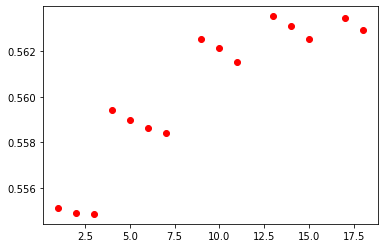

In [59]:
import csv
from matplotlib import pyplot as plt
import pandas as pd

scoresfile='/glade/work/rfisher/ilamb/ILAMB/MODELS/RTM_ens3/_build/scores.csv'      

df = pd.read_csv(scoresfile)  
#print(df)
v = [None] *19
alb=df.loc[8]
df.dtypes
data_top = df.head() 
#print(data_top)
for col in df.columns:
    print(col)
list(df.columns)
v[i]=float((df.loc[8]['RTM_ens3_case_1']))
#print(v)
#alb.Albedo=pd.to_numeric(alb.Albedo)
#alb=alb.astype(float)
#gpp.plot()
vs=range(0,19)
for i in vs:
    casen="RTM_ens3_case_"+str(i)
    print(casen)
    try:
        v[i]=float((df.loc[8][casen]))
    except:
        v[i]=np.nan
x_data = list(range(0,19))
print(x_data)
print(v)
plt.scatter(x_data, v, c='r', label='data')
